# 推理引擎ONNX Runtime部署-预测摄像头实时画面-中文

使用 ImageNet 预训练图像分类模型，预测摄像头实时画面。

本代码需在`连接摄像头的本地`运行，不能在云GPU平台运行。

同济子豪兄：https://space.bilibili.com/1900783

测试运行环境：Macbook Pro

## 导入工具包

In [2]:
import os

import numpy as np
import pandas as pd

import cv2

from tqdm import tqdm # 进度条

import torch
import torch.nn.functional as F
from torchvision import models

import onnxruntime

from PIL import Image, ImageFont, ImageDraw

import matplotlib.pyplot as plt
%matplotlib inline

## 导入中文字体

In [25]:
# 下载中文字体文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [4]:
# 导入中文字体，指定字体大小
font = ImageFont.truetype('SimHei.ttf', 32)

## 载入 onnx 模型

In [6]:
ort_session = onnxruntime.InferenceSession('resnet18_imagenet.onnx')

## 载入ImageNet 1000图像分类标签

ImageNet 1000类别中文释义：https://github.com/ningbonb/imagenet_classes_chinese

In [7]:
# 载入ImageNet 1000图像分类标签
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['Chinese']

In [8]:
# idx_to_labels

## 图像预处理

In [9]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 获取摄像头的一帧画面

### 调用摄像头获取一帧画面

In [26]:
# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

In [27]:
img_bgr.shape

(720, 1280, 3)

### 画面转成 RGB 的 Pillow 格式

In [38]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB

In [39]:
img_pil = Image.fromarray(img_rgb)

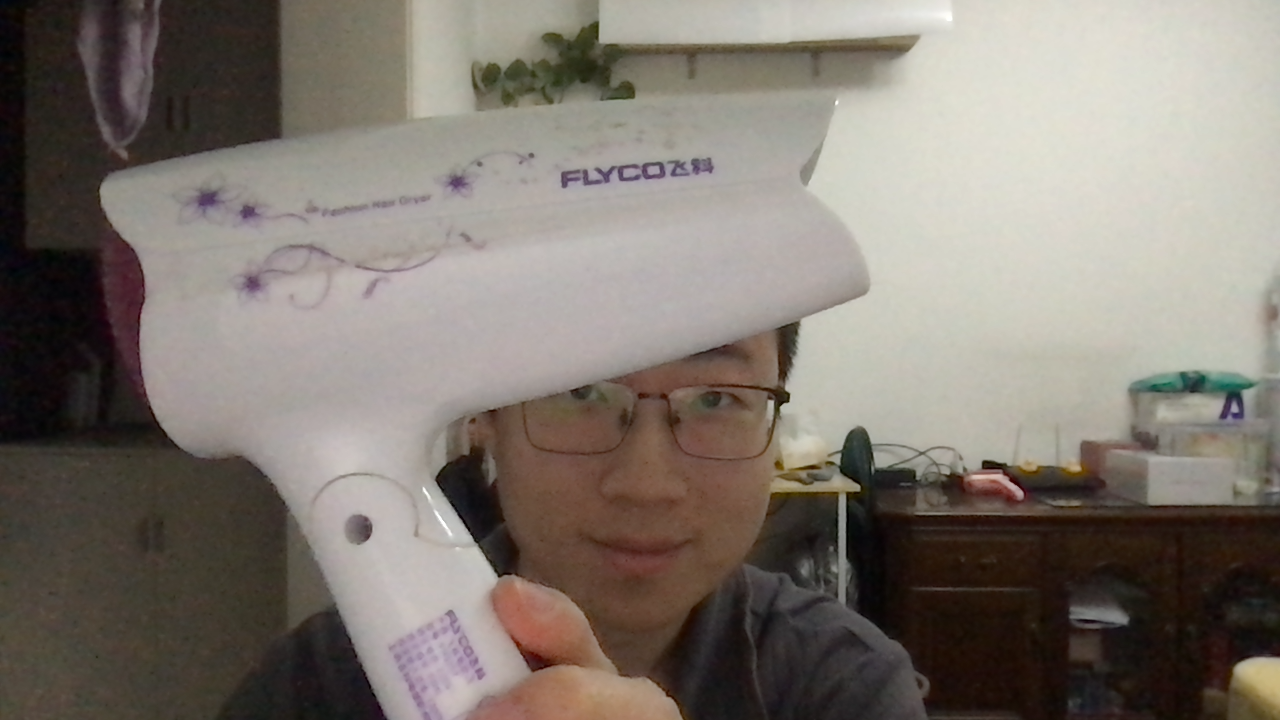

In [40]:
img_pil

### 预处理

In [41]:
input_img = test_transform(img_pil)
input_tensor = input_img.unsqueeze(0).numpy()

### ONNX Runtime推理预测

In [42]:
# onnx runtime 输入
ort_inputs = {'input': input_tensor}

# onnx runtime 输出
pred_logits = ort_session.run(['output'], ort_inputs)[0]
pred_logits = torch.tensor(pred_logits)

### 获得预测结果

In [43]:
import torch.nn.functional as F
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [44]:
pred_softmax.shape

torch.Size([1, 1000])

### 解析top-n预测结果的类别和置信度

In [45]:
## 解析图像分类预测结果
n = 5
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

### 在图像上写中文

In [46]:
draw = ImageDraw.Draw(img_pil) 

for i in range(len(confs)):
    pred_class = idx_to_labels[pred_ids[i]]
    
    # 写中文：文字坐标，中文字符串，字体，rgba颜色
    text = '{:<15} {:>.3f}'.format(pred_class, confs[i]) # 中文字符串
    draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
    
img_rgb = np.array(img_pil) # PIL 转 array

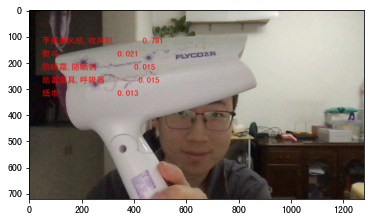

In [47]:
plt.imshow(img_rgb)
plt.show()

## 处理单帧画面的函数（中文）

In [48]:
# 处理帧函数
def process_frame(img_bgr):
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB
    img_pil = Image.fromarray(img_rgb) # array 转 PIL

    ## 预处理
    input_img = test_transform(img_pil) # 预处理
    input_tensor = input_img.unsqueeze(0).numpy()
    
    ## onnx runtime 预测
    ort_inputs = {'input': input_tensor} # onnx runtime 输入
    pred_logits = ort_session.run(['output'], ort_inputs)[0] # onnx runtime 输出
    pred_logits = torch.tensor(pred_logits)
    pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算
    
    ## 解析图像分类预测结果
    n = 5
    top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
    confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度
    
    
    ## 在图像上写中文
    draw = ImageDraw.Draw(img_pil) 
    for i in range(len(confs)):
        pred_class = idx_to_labels[pred_ids[i]]
        
        # 写中文：文字坐标，中文字符串，字体，rgba颜色
        text = '{:<15} {:>.3f}'.format(pred_class, confs[i]) # 中文字符串
        draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
        
    img_rgb = np.array(img_pil) # PIL 转 array
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR) # RGB转BGR
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)  
    # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
    img_bgr = cv2.putText(img_bgr, 'FPS  '+str(int(FPS)), (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 4, cv2.LINE_AA)
    return img_bgr

## 调用摄像头获取每帧（模板）

In [49]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    # 获取画面
    success, frame = cap.read()
    if not success:
        print('Error')
        break
    
    ## !!!处理帧函数
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()